# Convolutional Variational Autoencoder

**Dataset**: MNIST Dataset from Keras API

**Reference**: [Convolutional Variational Autoencoder](https://www.tensorflow.org/tutorials/generative/cvae)

A VAE is a `probabilistic` take on the autoencoder, a model which takes high dimensional input data and compresses it into a smaller representation. Unlike a traditional autoencoder, which maps the input onto a latent vector, a VAE maps the input data into the parameters of a `probability distribution`, such as the `mean` and `variance` of a `Gaussian`. This approach produces a continuous, structured latent space, which is useful for image generation.



![](https://learnopencv.com/wp-content/uploads/2020/11/vae-diagram-1-1024x563.jpg)

In [1]:
! pip install tensorflow-probability

# to generate gifs
! pip install imageio
! pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-1rs9tw16
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-1rs9tw16
  Resolved https://github.com/tensorflow/docs to commit 05efbeb489102ffd8c131a0da118c43dfe13c82f
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2023.9.4.19335-py3-none-any.whl size=184104 sha256=9b9f97986ab15562ac4a2c7f7190dc41df2793d8c43a6c60ecba7cbc33d69875
  Stored in directory: /tmp/pip-ephem-wheel-cache-3jkqzoyw/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs


In [2]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time

### VAE Implementation

* Create Model including Encoder and Decoder models
* Use Reparameterization trick for mapping
* KL divergence loss
* Reconstruction loss
* Sampling

### Load and Preprocess Data

In [3]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
def preprocess_images(images):
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
  return np.where(images > .5, 1.0, 0.0).astype('float32')

In [5]:
train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

In [6]:
TRAIN_SIZE = 60000
TEST_SIZE = 10000

BATCH_SIZE = 32

In [7]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images).shuffle(TRAIN_SIZE).batch(BATCH_SIZE))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images).shuffle(TEST_SIZE).batch(BATCH_SIZE))

### Encoder Network

This defines the approximate posterior distribution `q(z|x)`, which takes as input an observation and outputs a set of parameters for specifying the conditional distribution of the latent representation `z`. In this example, simply model the distribution as a `diagonal Gaussian`, and the network outputs the `mean` and `log-variance` parameters of a factorized Gaussian. Output `log-variance` instead of the variance directly for numerical stability.

In [8]:
def create_encoder_model(input_shape, latent_dim):
  model = tf.keras.Sequential(
  [
      tf.keras.layers.InputLayer(input_shape=input_shape),
      tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
      tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
      tf.keras.layers.Flatten(),
      # No activation
      tf.keras.layers.Dense(latent_dim + latent_dim),  # One for mean and oen for variance
  ])
  return model

### Decoder network

This defines the conditional distribution of the observation p(x|z), which takes a latent sample as input and outputs the parameters for a conditional distribution of the observation. Model the latent distribution prior p(z) as a unit Gaussian.

In [9]:
def create_decoder_model(latent_dim):
    model = tf.keras.Sequential(
    [
        tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
        tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
        tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
        tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu'),
        tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
        # No activation
        tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same'),
    ])
    return model

### Convolutional Variational Autoencoder (CVA) Model

In [10]:
INPUT_SHAPE = (28,28,1)

In [11]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = create_encoder_model(INPUT_SHAPE, latent_dim)
    self.decoder = create_decoder_model(latent_dim)

  @tf.function
  def sample(self, eps=None):
    # Sampling (generate/predict) from test data
    # IF there is no test data, create synthetic random normal test data
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)  # Split latent space into mean and variance vectors
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)  # epsilon is generally chosen random normal tensor
    return eps * tf.exp(logvar * .5) + mean   # z = μ + ε*log(σ)*0.5

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)  # Give latent vector as input
    # We need logits (output values), not probabilities
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

### Reparameterization trick

To generate a sample `z` for the decoder during training, you can sample from the latent distribution defined by the parameters outputted by the encoder, given an input observation `x`. However, this sampling operation creates a bottleneck because `backpropagation cannot flow through a random node`. To address this issue, we use a `reparameterization trick`.

![](https://learnopencv.com/wp-content/uploads/2020/11/reparam-vae-1024x479.jpg)

![](https://mlarchive.com/wp-content/uploads/2022/10/Screen-Shot-2022-10-08-at-1.59.49-PM-1-768x225.png)

Generate epsilon from standard normal distribution. The latent variable z is now generated by a function of mean, variance and epsilon, which would enable the model to backpropagate gradients in the encoder through mean and variance respectively, while maintaining stochasticity through epsilon.

### Loss Functions and Optimizer

![](https://miro.medium.com/v2/resize:fit:720/0*jhi0jGQl9rZoqOvI)

### Optimizer

In [12]:
optimizer = tf.keras.optimizers.Adam(1e-4)

### Log-normal distribution with Probability density function (PDF)

PDF(x; μ, σ) = (1 / (xσ√(2π))) * exp(-((ln(x) - μ)^2 / (2σ^2)))

Where:

x is the value you want to calculate the probability density for.

μ is the mean (average) of the natural logarithm of the data.

σ is the standard deviation of the natural logarithm of the data.

π is the mathematical constant Pi (approximately 3.14159).

ε random normal tensor

### Negative Log Likelihood (NLL)

Negative log likelihood of a sample given a Gaussian distribution with a given mean and log variance formula:

Negative Log Likelihood = `-0.5 * Σ[(sample - mean)^2 * exp(-logvar) + logvar + log(2π)]`
  
The negative log likelihood (NLL) for a Gaussian distribution is a measure of how well the Gaussian distribution fits a given data point (sample).
  
Where:
* `sample`: input sample.
* `mean`: mean of the Gaussian distribution.
* `logvar`: logarithm of the variance of the Gaussian distribution.
* `log2pi`: logarithm of 2π.
* `raxis`: axis along which the summation is performed.

This formula calculates the `squared difference` between the observed `data point` and the `mean` of the `Gaussian`, divided by the exponential of the logarithm of the variance. It also includes a constant term related to the variance. The Negative log likelihood is often used as a loss function in probabilistic models like variational autoencoders `(VAEs)` and Gaussian mixture models (GMMs) to estimate model parameters by minimizing the NLL with respect to those parameters.

In [13]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)  # log2pi constant
  # Calculate the log probability density function
  # This formula corresponds to the negative log likelihood of a sample given a
  # Gaussian distribution with a given mean and log variance.
  # Negative Log Likelihood = -0.5 * Σ[(sample - mean)^2 * exp(-logvar) + logvar + log(2π)]
  # The negative log likelihood (NLL) for a Gaussian distribution is a measure of how well the Gaussian distribution fits a given data point (sample).
  # Where:
  # sample: input sample.
  # mean: mean of the Gaussian distribution.
  # logvar: logarithm of the variance of the Gaussian distribution.
  # log2pi: logarithm of 2π.
  # raxis: axis along which the summation is performed.

  return tf.reduce_sum(-.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi), axis=raxis)

### Sigmoid Cross Entropy

There are many kinds of loss functions. One such function is the Sigmoid cross entropy function of TensorFlow. The sigmoid function or logistic function is the function that generates an `S-shaped curve`. This function is used to predict probabilities therefore, the range of this function lies between `0` and `1`.

![](https://i.stack.imgur.com/7poun.png)


Sigmoid Cross Entropy is used for soft binary labels. A soft label is one that has a measure of likelihood. This function can also be used for hard labels. It measures the `probability of error` in tasks that have `two outcomes`.

Sigmoid Cross Entropy loss = -Σ\[(yi logσ(sigmoid(zi)) + (1 - yi) log(1 - σ.sigmoid(zi)))\]


Reference: https://www.geeksforgeeks.org/sigmoid-cross-entropy-function-of-tensorflow/


### A lower-variance estimator for the ELBO

![](https://miro.medium.com/v2/resize:fit:828/0*-eguD2kMjNLu8ESE)

In [14]:
def compute_loss(model, x):
  '''
  model: CVAE model
  x: train batch
  '''
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)  # z = μ + ε*log(σ)*0.5
  x_logit = model.decode(z)  # Give latent vector (z) as input

  # Sigmoid cross entropy
  # loss = -(y_true log(sigmoid(y_pred)) + (1 - y_true) log(1 - sigmoid(y_pred)))
  # z * -log(sigmoid(x)) + (1 - z) * -log(1 - sigmoid(x))
  # when: x = logits, z = labels
  # This computes the binary cross-entropy loss between the generated logits
  # x_logit and the original input data x. This term encourages the generated
  # data to be similar to the input data.
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)

  # This calculates the negative log likelihood of the data under the generative
  # distribution. It sums the cross-entropy loss across all dimensions.
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])

  # This computes the log probability of the sampled latent variables `z` under a
  # standard normal distribution.
  logpz = log_normal_pdf(z, 0., 0.)

  # This calculates the log probability of the sampled latent variables `z` under
  # the approximate posterior distribution, which is determined by the encoder.
  logqz_x = log_normal_pdf(z, mean, logvar)

  # Combination of the negative log likelihood (logpx_z), the log probability of
  # the prior distribution (logpz), and the negative log probability of the
  # approximate posterior distribution (logqz_x). This loss function encourages
  # the VAE to generate data that is close to the input data while regularizing
  # the latent variable distribution.
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)

In [15]:
@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.

  model: CVAE model
  x: train batch
  optimizer: Model optimizer
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)

  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

### Training the Model

* Start by iterating over the dataset
* During each iteration, pass the image to the encoder to obtain a set of `mean` and `log-variance` parameters of the approximate posterior `q(z|x)` then apply the reparameterization trick to sample from `q(z|x)`
* Pass the `reparameterized samples` to the decoder to obtain the logits of the generative distribution `p(x|z)`

In [70]:
EPOCHS = 10
NUM_EXAMPLES_TO_GENERATE = 16  # Number of examples to generate as an output of the CVAE
LATENT_DIM = 2  # Dimensionality of the latent space to a plane for visualization later

### Create Convolutional Variational Autoencoder (CVAE) Model

In [68]:
cvae_model = CVAE(LATENT_DIM)

### Generating Images

In [48]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)  # decode latent space as much as number of test_sample

  fig = plt.figure(figsize=(4, 4))
  # Show 4x4:16 images grayscale
  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  # Save generated figure in .png format
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

### Create Data/Dataset to sampling (generation/prediction) from CVAE

In [49]:
# Pick a sample of the test set for generating output images
assert BATCH_SIZE >= NUM_EXAMPLES_TO_GENERATE

# IF you have test dataset, get bunch/batch of data from it to generate and visualize
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:NUM_EXAMPLES_TO_GENERATE, :, :, :]

# IF you have no test data, create random normal test data to generate/predict new data
random_vector_for_generation = tf.random.normal(shape=[NUM_EXAMPLES_TO_GENERATE, LATENT_DIM])

In [50]:
test_sample.shape

TensorShape([16, 28, 28, 1])

### Visualize Test sample

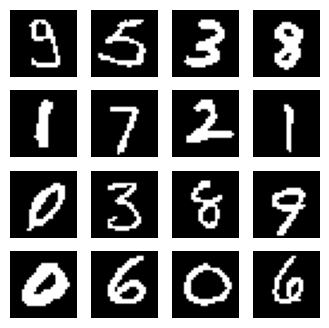

In [51]:
fig = plt.figure(figsize=(4, 4))
# Show 4x4:16 test sample images grayscale
for i in range(test_sample.shape[0]):
  plt.subplot(4, 4, i + 1)
  plt.imshow(test_sample[i, :, :, 0], cmap='gray')
  plt.axis('off')

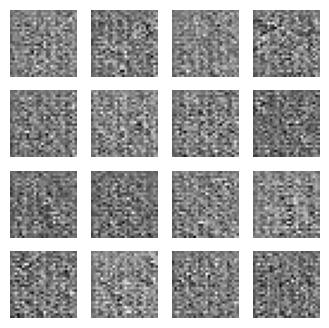

In [71]:
generate_and_save_images(cvae_model, 0, test_sample)

In [62]:
for train_batch in train_dataset.take(1):
  print("train_batch.shape: ",train_batch.shape)

train_batch.shape:  (32, 28, 28, 1)


### Start Training the model

Epoch: 10, Test set ELBO: -156.822265625, time elapse for current epoch: 7.784191608428955


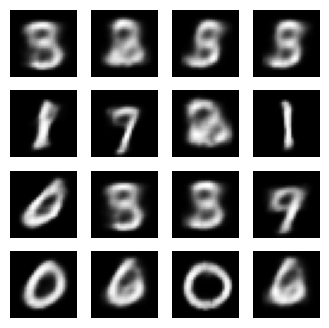

In [53]:
for epoch in range(1, EPOCHS + 1):
  start_time = time.time()  # Get instant time to compute spent time during training

  for train_batch in train_dataset:  # Loop until all batches feed model
    train_step(cvae_model, train_batch, optimizer)

  end_time = time.time()    # Get instant time to compute spent time during training

  loss = tf.keras.metrics.Mean()

  # Compute loss for Test data (evaluate model) after each epoch
  for test_batch in test_dataset:
    loss(compute_loss(cvae_model, test_batch))

  elbo = -loss.result()

  display.clear_output(wait=False)  # Clear plot output after each epoch
  print(f'Epoch: {epoch}, Test set ELBO: {elbo}, time elapse for current epoch: {(end_time - start_time)}')

  # Generate (and save) images after each epoch
  generate_and_save_images(cvae_model, epoch, test_sample)

In [54]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

(-0.5, 399.5, 399.5, -0.5)

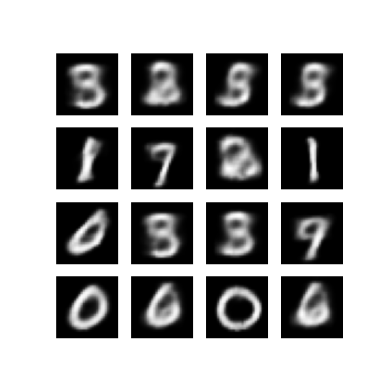

In [55]:
plt.imshow(display_image(epoch))
plt.axis('off')  # Display images

### Create GIF

In [56]:
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-56-a6dbd3b71488>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-56-a6dbd3b71488>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



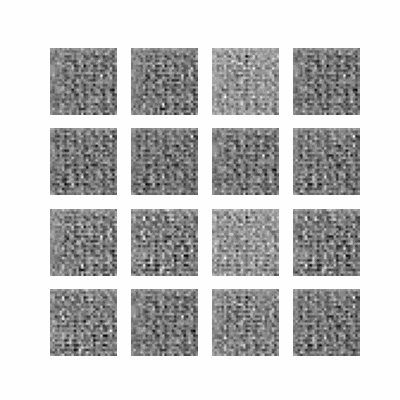

In [57]:
import tensorflow_docs.vis.embed as embed

embed.embed_file(anim_file)

### Display a 2D manifold of digits from the latent space

In [58]:
def plot_latent_images(model, n, digit_size=28):
  """Plots n x n digit images decoded from the latent space."""

  norm = tfp.distributions.Normal(0, 1)
  grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
  grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
  image_width = digit_size*n
  image_height = image_width
  image = np.zeros((image_height, image_width))

  for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
      z = np.array([[xi, yi]])
      x_decoded = model.sample(z)
      digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
      image[i * digit_size: (i + 1) * digit_size,
            j * digit_size: (j + 1) * digit_size] = digit.numpy()

  plt.figure(figsize=(10, 10))
  plt.imshow(image, cmap='Greys_r')
  plt.axis('Off')
  plt.show()

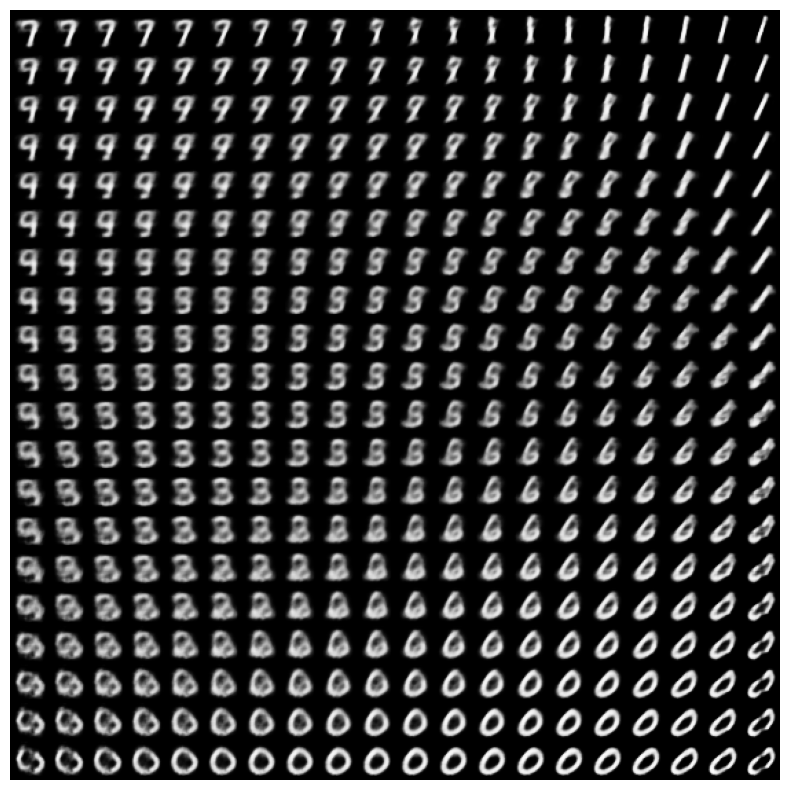

In [63]:
plot_latent_images(cvae_model, 20)

### Reference

[Convolutional Variational Autoencoder](https://www.tensorflow.org/tutorials/generative/cvae)

https://learnopencv.com/variational-autoencoder-in-tensorflow/

https://mlarchive.com/deep-learning/variational-autoencoders-a-vanilla-implementation/

https://mbernste.github.io/posts/elbo/

https://abhinavkumarv29.medium.com/elbo-derivation-for-vae-variational-autoencoder-bb048fa1f55e